#**Library**

In [ ]:

import os
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.feature_selection import RFE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score

from sklearn import metrics
import math

random.seed(10)
np.random.seed(10)
%matplotlib inline
import time
from time import process_time

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**1. Dataset_Preprocessing**

##LUFlow Dataset (2020)

###Step 1. Combine the files of the dataset

In [ ]:
luflow_csv_files = ('2020.07.01',
                    '2020.07.02',
                    '2020.07.03',
                    '2020.07.04',
                    '2020.07.05',
                    '2020.07.06',
                    '2020.07.07',
                    '2020.07.08',
                    '2020.07.09',
                    '2020.07.10',
                    '2020.07.11',
                    '2020.07.12',
                    '2020.07.13',
                    '2020.07.14',
                    '2020.07.15',
                    '2020.07.16',
                    '2020.07.17',
                    '2020.07.18',
                    '2020.07.19',
                    '2020.07.20',
                    '2020.07.21',
                    '2020.07.22',
                    '2020.07.23',
                    '2020.07.24',
                    '2020.07.25',
                    '2020.07.26',
                    '2020.07.27',
                    '2020.07.28',
                    '2020.07.29',
                    '2020.07.30',
                    '2020.07.31',
                    )

In [ ]:
# Define the function to combine seperate files of a dataset
# Besides combining the files, it has two additional functionality:
# 1. Replace the replacement character (\uFFFD) with '-', which is needed for the CIC-IDS2017 dataset
# 2. Down sample the dataset. If the reduce_sample_size parameter is set to true,
#    only 10% of the dataset will be randomly selected and saved.
def combine_csv_files(dataset: str, file_names: tuple, reduce_sample_size: bool = False):

    # create a new directory to place the combined dataset
    os.makedirs('/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_combined', exist_ok=True)

    # remove the dataset if it already exist
    merged_dataset_directory = f'/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_combined/{dataset}.csv'
    if os.path.isfile(merged_dataset_directory):
        os.remove(merged_dataset_directory)
        print(f'original file({merged_dataset_directory}) has been removed')

    for (file_index, file_name) in enumerate(file_names):
        with open(f"/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/{dataset}/{file_name}.csv", 'r') as file, open(merged_dataset_directory, 'a') as out_file:
            for (line_index, line) in enumerate(file):

                # only the header of the first file will be taken
                if 'Label' in line or 'label' in line:
                    if file_index != 0 or line_index != 0:
                        continue
                elif reduce_sample_size:
                    if random.randint(1, 10) > 1:
                        continue
                # replace the replacement character (\uFFFD) with '-' if exist
                out_file.write(line.replace(' ï¿½ ', '-'))


In [ ]:
combine_csv_files(dataset='LUFlow',
                    file_names=luflow_csv_files,
                    reduce_sample_size=True)

original file(/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_combined/LUFlow.csv) has been removed


###Step 2. Preliminary analysis

In [ ]:
# read the dataset
luflow2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_combined/LUFlow.csv')
luflow2020.head()

,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration
0,0.000000,0,2896,786,9200.0,4.263922,2,0,6,786,32862.0,1593574200046275,1593574200046255,12348.318,benign,0.000020
1,0.285714,0,10136,786,9200.0,2.710831,7,3,6,786,32898.0,1593574199053693,1593574199051282,27476.982,benign,0.002411
2,0.000000,0,6074,786,9200.0,3.692507,5,0,6,786,32902.0,1593574200047203,159357420004712,22428.287,benign,0.000083
3,0.000000,0,2896,786,9200.0,4.803335,2,0,6,786,32902.0,1593574201053831,1593574201053819,13910.459,benign,0.000012
4,0.000000,0,0,786,32898.0,0.000000,1,0,6,786,9200.0,1593574202069599,1593574202069599,0.000,benign,0.000000


In [ ]:
print(f"Number of rows: {luflow2020.shape[0]}")
print(f"Number of columns: {luflow2020.shape[1]}")

Number of rows: 2506350
Number of columns: 16


In [ ]:
print("Columns in the dataset:")
luflow2020.columns

Columns in the dataset:


Index(['avg_ipt', 'bytes_in', 'bytes_out', 'dest_ip', 'dest_port', 'entropy',
       'num_pkts_out', 'num_pkts_in', 'proto', 'src_ip', 'src_port',
       'time_end', 'time_start', 'total_entropy', 'label', 'duration'],
      dtype='object')

In [ ]:
print('Class distribution:')
luflow2020['label'].value_counts()

Class distribution:


benign       1396168
malicious     905395
outlier       204787
Name: label, dtype: int64

In [ ]:
print('Class distribution (normalized):')
luflow2020['label'].value_counts()/luflow2020.shape[0]*100

Class distribution (normalized):


benign       55.705229
malicious    36.124045
outlier       8.170726
Name: label, dtype: float64

Check for null value

In [ ]:
luflow2020_null_count = luflow2020.isnull().sum()
luflow2020_null_count = luflow2020_null_count[luflow2020_null_count > 0]
print(f"Rows contain null value: \n{luflow2020_null_count}\n")

luflow2020_null_count = luflow2020_null_count / luflow2020.shape[0] * 100
print(f"Rows contain null value (percentage): \n{luflow2020_null_count}\n")

Rows contain null value: 
dest_port    29268
src_port     29268
dtype: int64

Rows contain null value (percentage): 
dest_port    1.167754
src_port     1.167754
dtype: float64



Check for columns that contain string values

In [ ]:
luflow2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506350 entries, 0 to 2506349
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   avg_ipt        float64
 1   bytes_in       int64  
 2   bytes_out      int64  
 3   dest_ip        int64  
 4   dest_port      float64
 5   entropy        float64
 6   num_pkts_out   int64  
 7   num_pkts_in    int64  
 8   proto          int64  
 9   src_ip         int64  
 10  src_port       float64
 11  time_end       int64  
 12  time_start     int64  
 13  total_entropy  float64
 14  label          object 
 15  duration       float64
dtypes: float64(6), int64(9), object(1)
memory usage: 306.0+ MB


Check for duplicates

In [ ]:
# check for duplicated column
luflow2020.columns[luflow2020.columns.value_counts() > 1]

Index([], dtype='object')

In [ ]:
luflow_duplicates = luflow2020[luflow2020.duplicated()]
print(f"{luflow_duplicates.shape[0]} rows are duplicates")
print(f"{luflow_duplicates.shape[0]/luflow2020.shape[0]*100:.2f}% of rows are duplicates")

508 rows are duplicates
0.02% of rows are duplicates


###Step 3. Dataset cleaning

In [ ]:
# remove rows contain missing value
luflow2020 = luflow2020.dropna(how='any')
luflow2020.shape

(2477082, 16)

In [ ]:
luflow2020 = luflow2020.drop_duplicates()
luflow2020.shape

(2476585, 16)

###Step 4. Dataset preparation

In [ ]:
# make duration in luflow into timestamp info
# takes in start and end
def make_timestamp(start, end):
  return int(end-start)

luflow2020['duration']=luflow2020.apply(lambda x: make_timestamp(start = x['time_start'], end = x['time_end']), axis=1)

# drop the time_end column
luflow2020=luflow2020.drop(['time_end'], axis=1)
luflow2020=luflow2020.drop(['time_start'], axis=1)

In [ ]:
attack = luflow2020[luflow2020['label']=='malicious']
benign = luflow2020[luflow2020['label']=='benign']

data1 = attack.sample(500000)
data2 = benign.sample(500000)
luflow2020 = pd.concat([data1, data2])
del attack
del benign

luflow2020 = luflow2020.sample(frac=1).reset_index(drop=True)
luflow2020['label'].value_counts()

malicious    500000
benign       500000
Name: label, dtype: int64

###Step 5. Save the dataset

In [ ]:
# function to save the cleaned dataset
def save_cleaned_dataset(dataframe: pd.DataFrame,dataset: str, tag: str = ""):
    # create a new directory to save the cleaned dataset
    os.makedirs('/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_cleaned', exist_ok=True)

    if not(tag == ""):
        tag = "_" + tag

    dataframe.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_cleaned/{dataset}{tag}.csv', index=False)

In [ ]:
save_cleaned_dataset(dataframe=luflow2020, dataset='LUFlow')



##LUFlow Dataset (2021)

In [ ]:
luflow2021_csv_files = ('2021.01.01',
                        '2021.01.02',
                        '2021.01.03',
                        '2021.01.04',
                        '2021.01.05',
                        '2021.01.06',
                        '2021.01.07',
                        '2021.01.08',
                        '2021.01.09',
                        '2021.01.10',
                        '2021.01.11',
                        '2021.01.12',
                        '2021.01.13',
                        '2021.01.14',
                        '2021.01.15',
                        '2021.01.17',
                        '2021.01.18',
                        '2021.01.19',
                        '2021.01.20',
                        '2021.01.22',
                        '2021.01.23',
                        '2021.01.24',
                        '2021.01.25',
                        '2021.01.26',
                        '2021.01.27',
                        '2021.01.28',
                        '2021.01.29',
                        '2021.01.30',
                        '2021.01.31',
                        )

In [ ]:
combine_csv_files(dataset='LUFlow_2021',
                    file_names=luflow2021_csv_files,
                    reduce_sample_size=True)

original file(/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_combined/LUFlow_2021.csv) has been removed


In [ ]:
luflow2021 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_combined/LUFlow_2021.csv')
luflow2021.head()

,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration
0,907.312500,754,32742,786,9092.0,1.111004,32,20,6,786,57148.0,1609467701725488,1609467672683006,37214.200,benign,29.042482
1,0.000000,0,0,786,40010.0,0.000000,1,1,6,786,9300.0,1609467690746479,1609467690746443,0.000,benign,0.000036
2,0.000000,174,29008,786,9092.0,1.127009,7,5,6,786,57148.0,1609467711729621,160946771172828,32888.370,benign,0.001341
3,0.000000,0,0,786,40012.0,0.000000,1,1,6,786,9300.0,1609467690746484,1609467690746469,0.000,benign,0.000015
4,1502.333333,664,13772,786,9200.0,2.341442,6,5,6,786,56330.0,1609467732753774,160946772373801,33801.062,benign,9.015764


In [ ]:
print(f"Number of rows: {luflow2021.shape[0]}")
print(f"Number of columns: {luflow2021.shape[1]}")

Number of rows: 2699669
Number of columns: 16


In [ ]:
print("Columns in the dataset:")
luflow2021.columns

Columns in the dataset:


Index(['avg_ipt', 'bytes_in', 'bytes_out', 'dest_ip', 'dest_port', 'entropy',
       'num_pkts_out', 'num_pkts_in', 'proto', 'src_ip', 'src_port',
       'time_end', 'time_start', 'total_entropy', 'label', 'duration'],
      dtype='object')

In [ ]:
print('Class distribution')
luflow2021['label'].value_counts()

Class distribution


benign       1638952
malicious     591372
outlier       469345
Name: label, dtype: int64

In [ ]:
print('Class distribution (normalized):')
luflow2020['label'].value_counts()/luflow2020.shape[0]*100

Class distribution (normalized):


malicious    50.0
benign       50.0
Name: label, dtype: float64

Check for null value

In [ ]:
luflow2021_null_count = luflow2021.isnull().sum()
luflow2021_null_count = luflow2021_null_count[luflow2021_null_count > 0]
print(f"Rows contain null value: \n{luflow2021_null_count}\n")

luflow2021_null_count = luflow2021_null_count / luflow2021.shape[0] * 100
print(f"Rows contain null value (percentage): \n{luflow2021_null_count}\n")

Rows contain null value: 
dest_port    33810
src_port     33810
dtype: int64

Rows contain null value (percentage): 
dest_port    1.252376
src_port     1.252376
dtype: float64



Check for infinity value

In [ ]:
print('Number of samples contains infinity value:')
np.isinf(luflow2021.iloc[:, :-2]).any(axis=1).sum()

Number of samples contains infinity value:


0

Check for columns that contain string values

In [ ]:
luflow2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2699669 entries, 0 to 2699668
Data columns (total 16 columns):
 #   Column         Dtype  
---  ------         -----  
 0   avg_ipt        float64
 1   bytes_in       int64  
 2   bytes_out      int64  
 3   dest_ip        int64  
 4   dest_port      float64
 5   entropy        float64
 6   num_pkts_out   int64  
 7   num_pkts_in    int64  
 8   proto          int64  
 9   src_ip         int64  
 10  src_port       float64
 11  time_end       int64  
 12  time_start     int64  
 13  total_entropy  float64
 14  label          object 
 15  duration       float64
dtypes: float64(6), int64(9), object(1)
memory usage: 329.5+ MB


Check for duplicates

In [ ]:
# check for duplicated column
luflow2021.columns[luflow2021.columns.value_counts() > 1]

Index([], dtype='object')

In [ ]:
luflow2021_duplicates = luflow2021[luflow2021.duplicated()]
print(f"{luflow2021_duplicates.shape[0]} rows are duplicates")
print(f"{luflow2021_duplicates.shape[0]/luflow2021.shape[0]*100:.2f}% of rows are duplicates")

290 rows are duplicates
0.01% of rows are duplicates


###Step 3. Dataset cleaning

In [ ]:
luflow2021 = luflow2021.dropna(how='any')
luflow2021.shape

(2665859, 16)

In [ ]:
luflow2021 = luflow2021.drop_duplicates()
luflow2021.shape

(2665569, 16)

###Step 4. Dataset preparation

In [ ]:
# make duration in luflow into timestamp info
# takes in start and end
def make_timestamp(start, end):
  return int(end-start)

luflow2021['duration']=luflow2021.apply(lambda x: make_timestamp(start = x['time_start'], end = x['time_end']), axis=1)

# drop the time_end column
luflow2021=luflow2021.drop(['time_end'], axis=1)
luflow2021=luflow2021.drop(['time_start'], axis=1)

In [ ]:
attack = luflow2021[luflow2021['label']=='malicious']
benign = luflow2020[luflow2020['label']=='benign']

data1 = attack.sample(500000)
data2 = benign.sample(500000)
luflow2021 = pd.concat([data1, data2])
del attack
del benign
luflow2021 = luflow2021.sample(frac=1).reset_index(drop=True)
luflow2021['label'].value_counts()

malicious    500000
benign       500000
Name: label, dtype: int64

###Step 5. Save the dataset

In [ ]:
save_cleaned_dataset(dataframe=luflow2021, dataset='LUFlow2021')

#**2. Data Visualisation**

##LUFlow Dataset (2020)

In [ ]:
luflow2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_cleaned/LUFlow.csv')
luflow2020.shape

(1000000, 14)

In [ ]:
luflow2020

,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,total_entropy,label,duration
0,0.000000,0,0,786,5900.0,0.000000,1,0,6,49877,48126.0,0.0000,malicious,0
1,44.750000,270,191,786,445.0,4.596345,6,6,6,8452,57118.0,2118.9153,malicious,338780
2,38.142857,34,29,786,5900.0,5.020695,7,10,6,207566,53833.0,316.3038,malicious,504469
3,0.500000,52,52,786,22.0,6.339774,1,2,6,14061,50302.0,659.3365,malicious,1875
4,0.000000,0,0,786,9200.0,0.000000,1,0,6,786,49294.0,0.0000,benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,144.000000,270,191,786,445.0,4.563821,6,6,6,24086,56395.0,2103.9214,malicious,1122474
999996,0.000000,0,0,786,8140.0,0.000000,2,1,6,10439,52096.0,0.0000,malicious,137193
999997,70.250000,270,191,786,445.0,4.588515,6,6,6,8452,9591.0,2115.3057,malicious,540831
999998,0.000000,0,3622,786,9200.0,5.076985,3,0,6,786,52608.0,18388.8420,benign,37


In [ ]:

print('Class distribution: ')
luflow2020['label'].value_counts()

Class distribution: 


malicious    500000
benign       500000
Name: label, dtype: int64

<Axes: xlabel='avg_ipt', ylabel='bytes_in'>

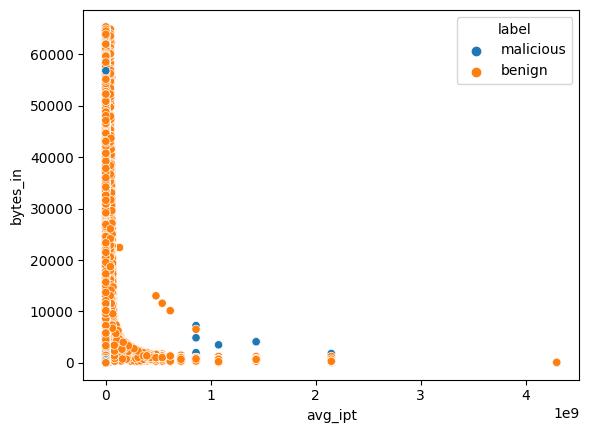

In [ ]:
sns.scatterplot(x=luflow2020['avg_ipt'], y=luflow2020['bytes_in'], hue=luflow2020['label'])

<Axes: xlabel='avg_ipt', ylabel='bytes_out'>

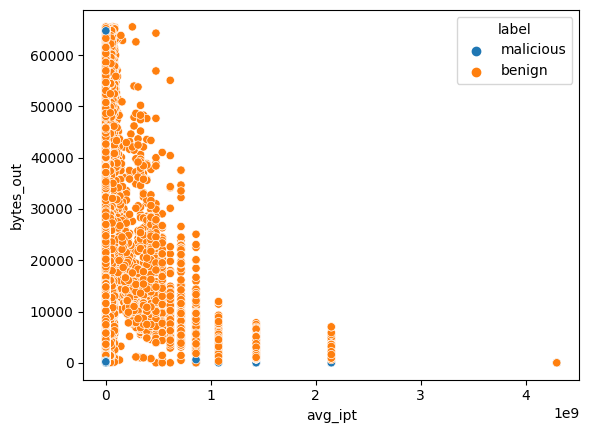

In [ ]:
sns.scatterplot(x=luflow2020['avg_ipt'], y=luflow2020['bytes_out'], hue=luflow2020['label'])

<Axes: xlabel='bytes_in', ylabel='bytes_out'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



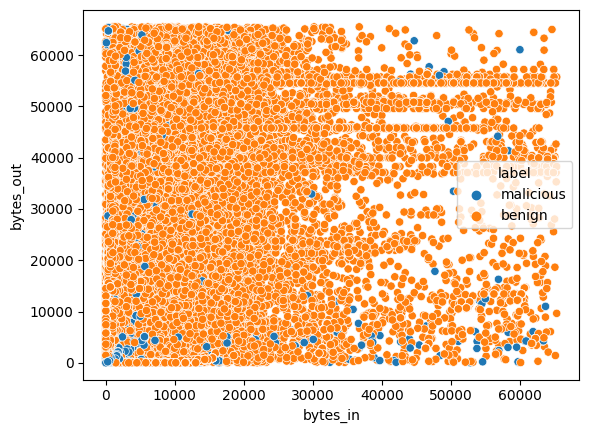

In [ ]:
sns.scatterplot(x=luflow2020['bytes_in'], y=luflow2020['bytes_out'], hue=luflow2020['label'])

<Axes: xlabel='num_pkts_out', ylabel='num_pkts_in'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



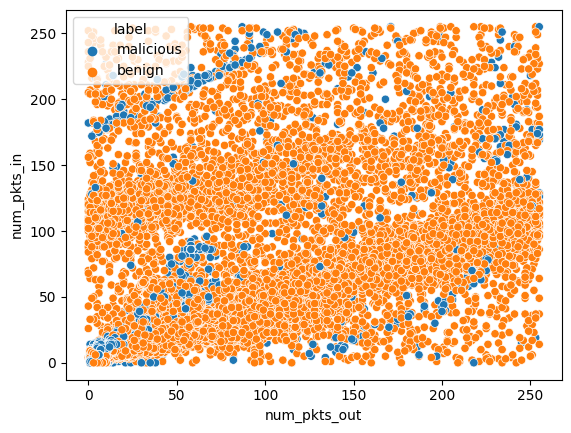

In [ ]:
sns.scatterplot(x=luflow2020['num_pkts_out'], y=luflow2020['num_pkts_in'], hue=luflow2020['label'])

<Axes: xlabel='num_pkts_in', ylabel='duration'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



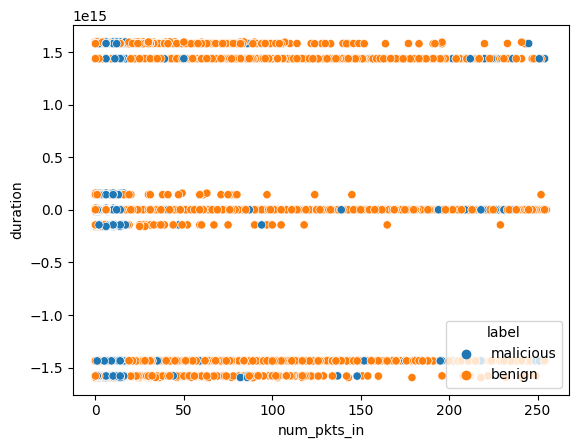

In [ ]:
sns.scatterplot(x=luflow2020['num_pkts_in'], y=luflow2020['duration'], hue=luflow2020['label'])

<Axes: xlabel='num_pkts_out', ylabel='duration'>

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



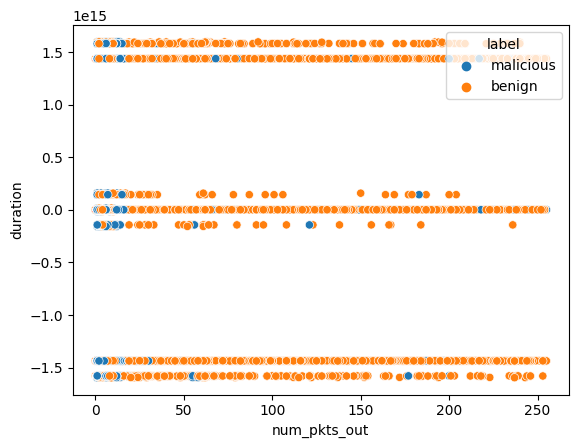

In [ ]:
sns.scatterplot(x=luflow2020['num_pkts_out'], y=luflow2020['duration'], hue=luflow2020['label'])

<ipython-input-54-8cbe14f8d1cb>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



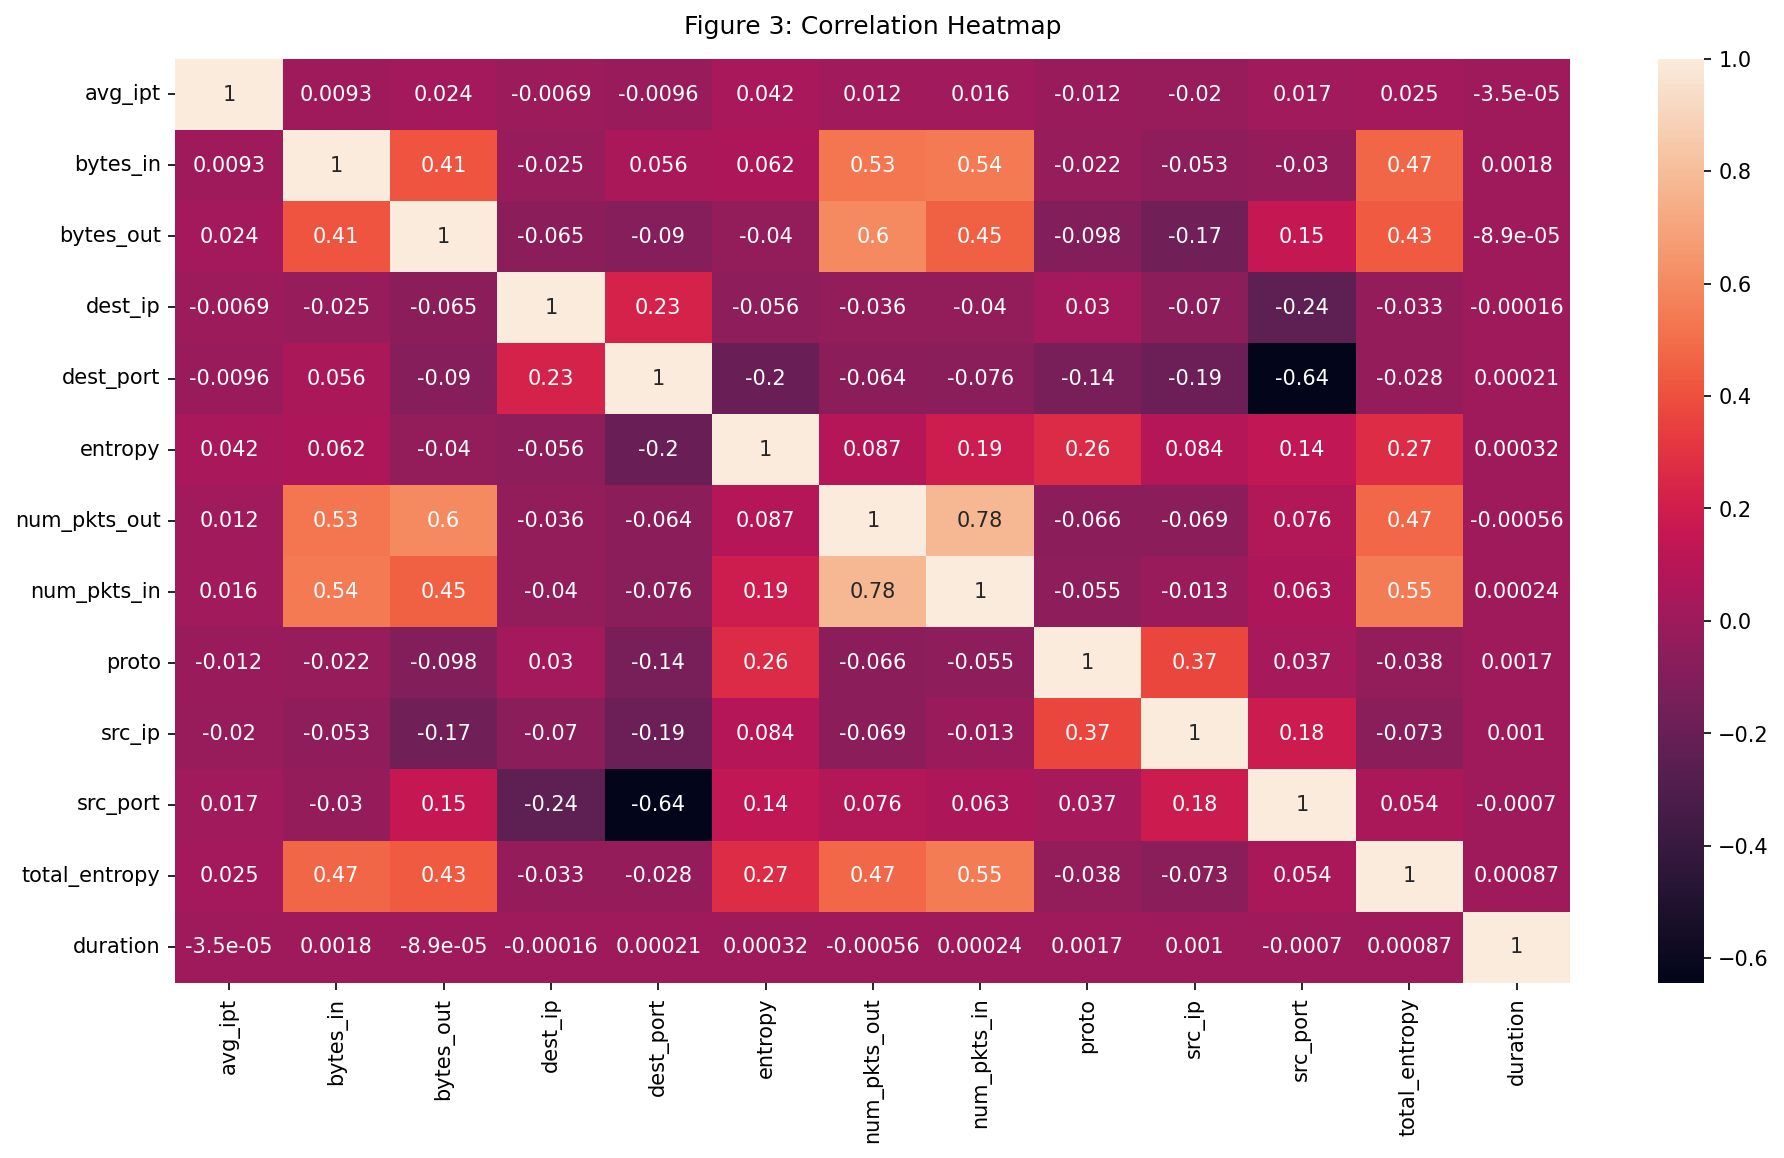

In [ ]:
plt.figure(figsize = (15,8), dpi=150)
heatmap=sns.heatmap(luflow2020.corr(), annot = True)
heatmap.set_title('Figure 3: Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [ ]:
luflow2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   avg_ipt        1000000 non-null  float64
 1   bytes_in       1000000 non-null  int64  
 2   bytes_out      1000000 non-null  int64  
 3   dest_ip        1000000 non-null  int64  
 4   dest_port      1000000 non-null  float64
 5   entropy        1000000 non-null  float64
 6   num_pkts_out   1000000 non-null  int64  
 7   num_pkts_in    1000000 non-null  int64  
 8   proto          1000000 non-null  int64  
 9   src_ip         1000000 non-null  int64  
 10  src_port       1000000 non-null  float64
 11  total_entropy  1000000 non-null  float64
 12  label          1000000 non-null  object 
 13  duration       1000000 non-null  int64  
dtypes: float64(5), int64(8), object(1)
memory usage: 106.8+ MB


##LUFlow Dataset (2021)

In [ ]:
LUFlow2021 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_cleaned/LUFlow2021.csv')
LUFlow2021.shape

(1000000, 14)

In [ ]:
LUFlow2021


,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,total_entropy,label,duration
0,181.50,270,191,786,445.0,4.572659,7,6,6,25019,63220.0,2107.9956,malicious,1449393028217464
1,0.00,8688,0,786,50846.0,3.115737,4,6,6,786,9200.0,27069.5210,benign,64
2,5.50,181,140,786,445.0,4.623701,2,3,6,12389,56936.0,1484.2079,malicious,94875
3,113.75,270,191,786,445.0,4.556691,6,6,6,45899,49747.0,2100.6345,malicious,895568
4,182.25,270,191,786,445.0,4.559118,6,6,6,7713,50744.0,2101.7534,malicious,-1449298823275846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,15.00,88,492,786,22.0,7.652452,4,3,6,786,36299.0,4438.4224,malicious,120432
999996,4.50,181,140,786,445.0,4.603482,1,2,6,7552,60942.0,1477.7177,malicious,9415
999997,0.00,0,0,786,46150.0,0.000000,3,0,6,786,9200.0,0.0000,benign,80
999998,0.00,0,0,786,445.0,0.000000,1,0,6,7713,64589.0,0.0000,malicious,0


In [ ]:

print('Class distribution: ')
LUFlow2021['label'].value_counts()

Class distribution: 


malicious    500000
benign       500000
Name: label, dtype: int64

<ipython-input-61-9678c39a2c8a>:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

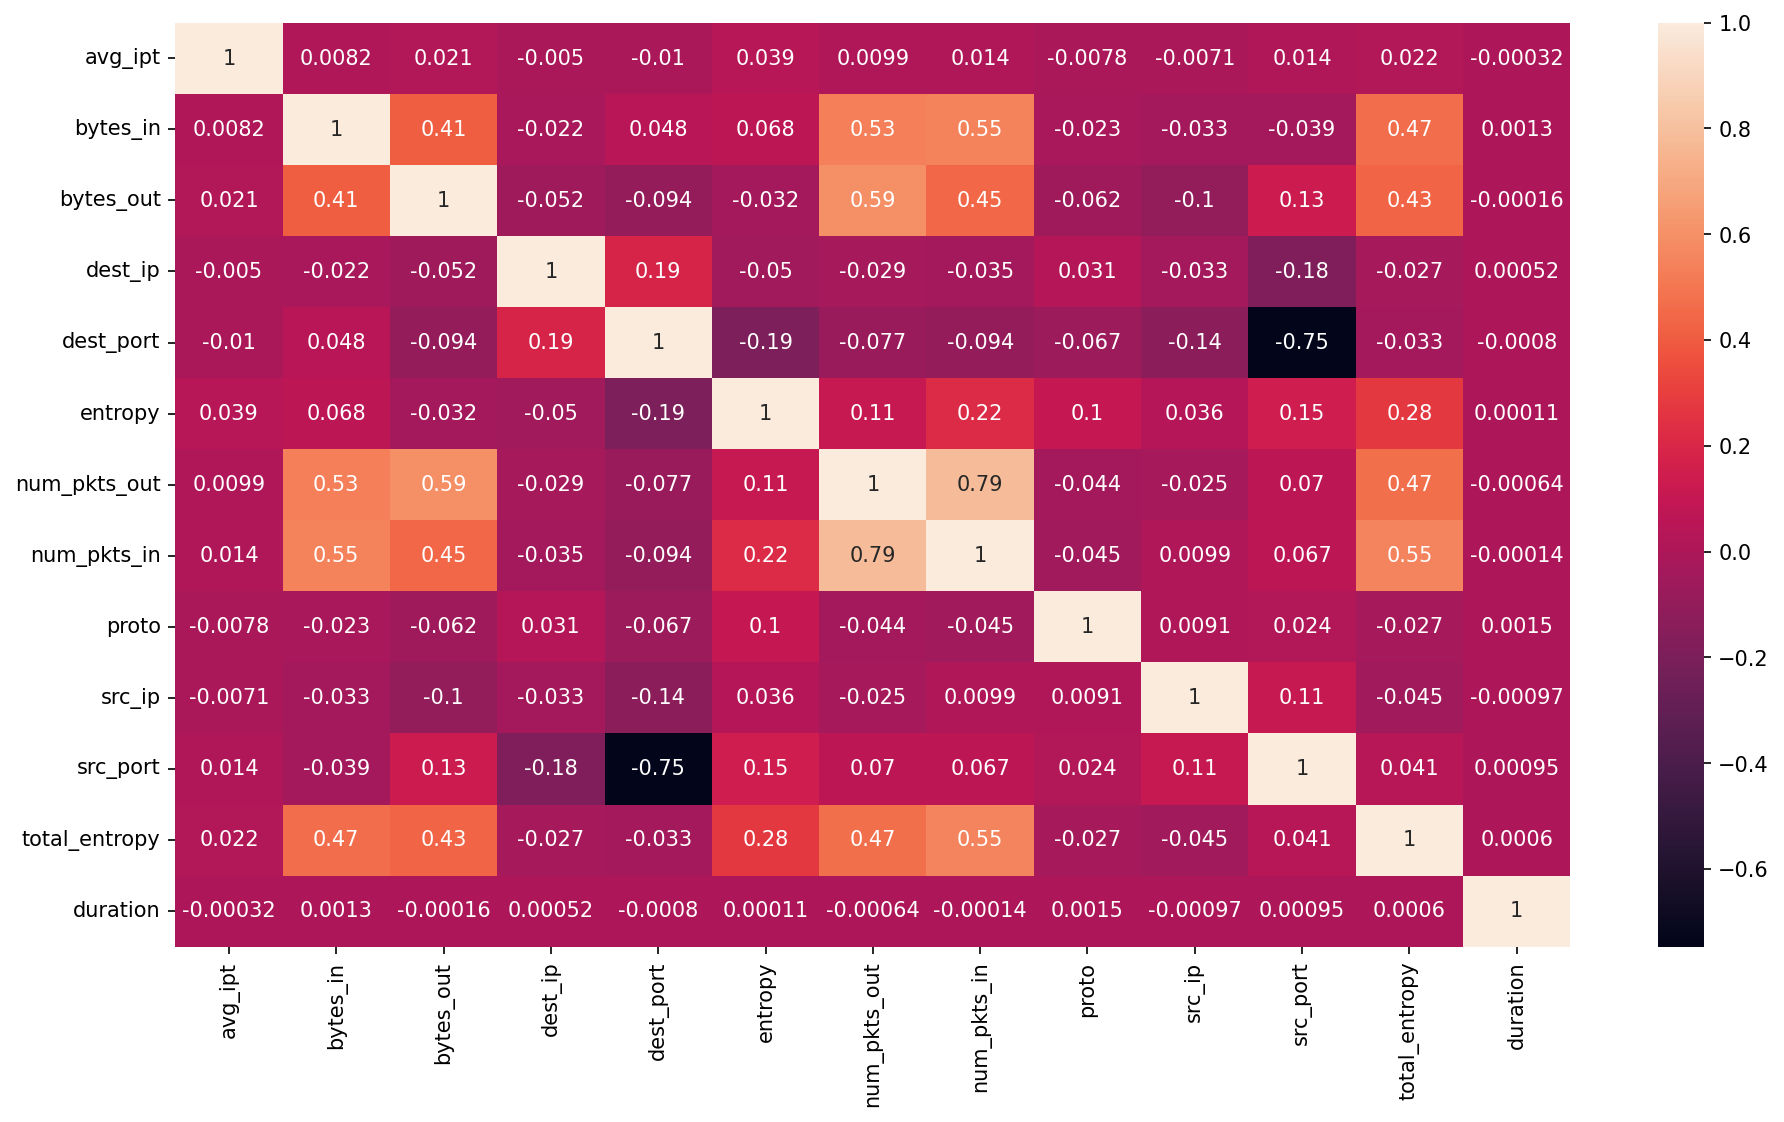

In [ ]:
plt.figure(figsize = (15,8), dpi=150)
sns.heatmap(LUFlow2021.corr(), annot = True)

In [ ]:
LUFlow2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   avg_ipt        1000000 non-null  float64
 1   bytes_in       1000000 non-null  int64  
 2   bytes_out      1000000 non-null  int64  
 3   dest_ip        1000000 non-null  int64  
 4   dest_port      1000000 non-null  float64
 5   entropy        1000000 non-null  float64
 6   num_pkts_out   1000000 non-null  int64  
 7   num_pkts_in    1000000 non-null  int64  
 8   proto          1000000 non-null  int64  
 9   src_ip         1000000 non-null  int64  
 10  src_port       1000000 non-null  float64
 11  total_entropy  1000000 non-null  float64
 12  label          1000000 non-null  object 
 13  duration       1000000 non-null  int64  
dtypes: float64(5), int64(8), object(1)
memory usage: 106.8+ MB


#**3. Feature Selection**

In [ ]:
luflow2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_cleaned/LUFlow.csv')
luflow2020.shape

(1000000, 14)

In [ ]:
luflow2020 = luflow2020.drop(['src_ip', 'dest_ip'], axis=1)
luflow2020.head()

,avg_ipt,bytes_in,bytes_out,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_port,total_entropy,label,duration
0,0.000000,0,0,5900.0,0.000000,1,0,6,48126.0,0.0000,malicious,0
1,44.750000,270,191,445.0,4.596345,6,6,6,57118.0,2118.9153,malicious,338780
2,38.142857,34,29,5900.0,5.020695,7,10,6,53833.0,316.3038,malicious,504469
3,0.500000,52,52,22.0,6.339774,1,2,6,50302.0,659.3365,malicious,1875
4,0.000000,0,0,9200.0,0.000000,1,0,6,49294.0,0.0000,benign,0


In [ ]:

luflow_2020_X = luflow2020.drop(['label'], axis=1)
luflow_2020_y = luflow2020['label']


In [ ]:
rfc = RandomForestClassifier()
rfc.fit(luflow_2020_X, luflow_2020_y)

RandomForestClassifier()

Top features: 
               importance score
feature                        
dest_port                 0.354
total_entropy             0.160
bytes_out                 0.129
src_port                  0.112
num_pkts_in               0.098
avg_ipt                   0.034
bytes_in                  0.029
entropy                   0.026
duration                  0.023
num_pkts_out              0.021
proto                     0.014


Text(0.5, 1.0, 'Figure 2: Importance Score')

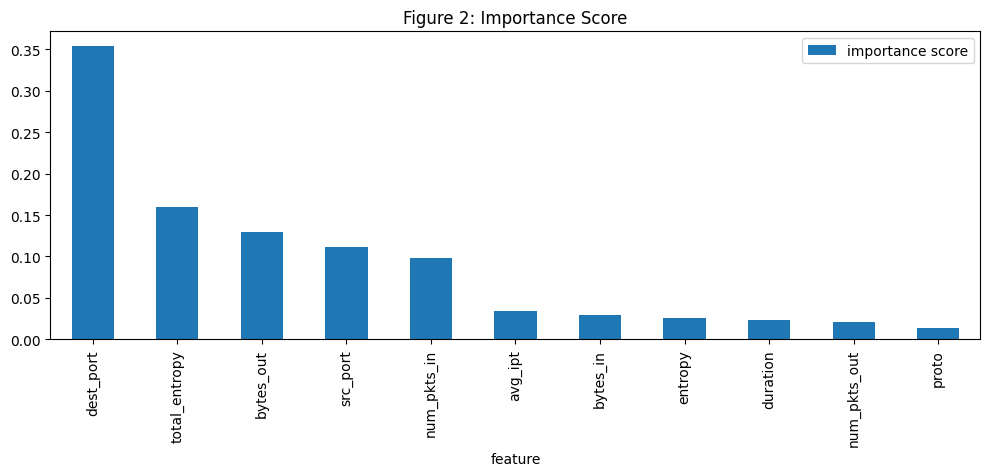

In [ ]:
#extract the importance score
score = np.round(rfc.feature_importances_, 3)
importance = pd.DataFrame({'feature': luflow_2020_X.columns,
                             'importance score': score})
importance = importance.sort_values('importance score', ascending=False).set_index('feature')

print(f"Top features: \n{importance}")

plt.rcParams['figure.figsize'] = (12, 4)
# ax.set_title('Figure 9: Accuracy of the models on training and testing dataset')
importance.plot.bar().set_title('Figure 2: Importance Score')

In [ ]:
def save_feature(features: pd.Series, dataset_name: str, algorithm: str, tag: str = ""):

    feature_count = features.shape[0]

    if not(tag == ""):
        tag = "_" + tag

    directory = '/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/features_selected'
    file_name = f"{dataset_name}_{algorithm}_{feature_count}{tag}"

    # create directory to save the file
    os.makedirs(directory, exist_ok=True)

    features.to_csv(f"{directory}/{file_name}.csv", index=False, columns=None)

    print(f"The features have been saved in {directory}/{file_name}.csv")

In [ ]:
# save the ranking of the features in a CSV file
features = pd.Series(importance.index[:], dtype='str')
save_feature(features=features,
            dataset_name='LUFlow',
            algorithm='RandomForestClassifier')

The features have been saved in /content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/features_selected/LUFlow_RandomForestClassifier_11.csv


###Step 3. Brute force

In [ ]:
# define ML models without optimized hyperparameter
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Extra Trees Classifier': ExtraTreesClassifier(),
    'KNN Classifier': KNeighborsClassifier()
}

In [ ]:
luflow_train_X, luflow_test_X, luflow_train_y, luflow_test_y = train_test_split(luflow_2020_X, luflow_2020_y, test_size=0.3)

In [ ]:
print('luflow_train_X',luflow_train_X.shape)
print('x_test_20',luflow_test_X.shape)
print('y_train_20',luflow_train_y.shape)
print('y_test_20',luflow_test_y.shape)

luflow_train_X (700000, 11)
x_test_20 (300000, 11)
y_train_20 (700000,)
y_test_20 (300000,)


In [ ]:
features

0         dest_port
1     total_entropy
2         bytes_out
3          src_port
4       num_pkts_in
5           avg_ipt
6          bytes_in
7           entropy
8          duration
9      num_pkts_out
10            proto
Name: feature, dtype: object

In [ ]:
feature_set = []
scalar = StandardScaler()
scores = []

for feature in features:
    feature_set.append(feature)
    print(f"Added feature {len(feature_set)} ({feature}) ...")

    test_X = luflow_test_X[feature_set]
    train_X = luflow_train_X[feature_set]

    # scale the dataset
    train_X_scaled = scalar.fit(train_X)
    train_X_scaled = scalar.transform(train_X)
    test_X_scaled = scalar.transform(test_X)

    score_temp = [len(feature_set)]

    for model in models:
        clf = models[model]
        clf.fit(train_X_scaled, luflow_train_y)

        prediction = clf.predict(test_X_scaled)
        accuracy = metrics.accuracy_score(luflow_test_y, prediction)

        score_temp.append(accuracy)

    scores.append(score_temp)


scores = np.array(scores)

Added feature 1 (dest_port) ...
Added feature 2 (total_entropy) ...
Added feature 3 (bytes_out) ...
Added feature 4 (src_port) ...
Added feature 5 (num_pkts_in) ...
Added feature 6 (avg_ipt) ...
Added feature 7 (bytes_in) ...
Added feature 8 (entropy) ...
Added feature 9 (duration) ...
Added feature 10 (num_pkts_out) ...
Added feature 11 (proto) ...


[0.99651    0.99616    0.99742333 0.99941667 0.99943667 0.99946333
 0.99947667 0.99947    0.99947333 0.99952    0.9995    ]
[0.99671333 0.99672333 0.99762333 0.99946333 0.99948    0.99952
 0.99951    0.99950667 0.99953333 0.9996     0.99960667]
[0.99668333 0.99703    0.99748    0.99943667 0.99943    0.99940667
 0.99941667 0.99939    0.99940667 0.99943667 0.99945667]
[0.99649333 0.99642333 0.99669667 0.99771    0.99739    0.99738
 0.99739667 0.99760667 0.99703    0.99794    0.99802333]


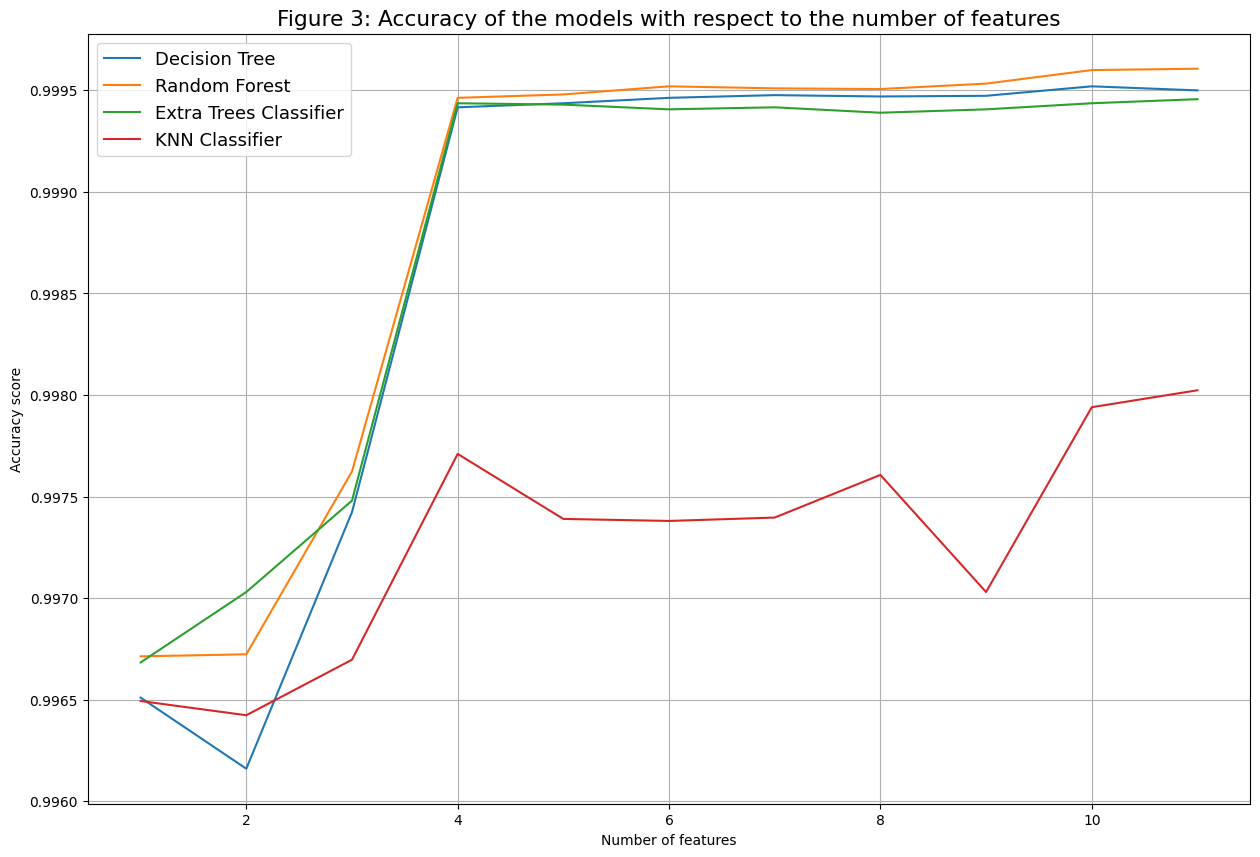

In [ ]:
plt.figure(figsize=(15, 10))
for index, model in enumerate(models):
  print(scores.T[index + 1])
  plt.plot(scores.T[0], scores.T[index + 1], label=model)

plt.rcParams.update({'font.size': 13})
plt.title('Figure 3: Accuracy of the models with respect to the number of features')
plt.xlabel('Number of features')
plt.ylabel('Accuracy score')
plt.legend()
plt.grid()
plt.show()

#**4. Optimize the models' hyperparameter**

In [ ]:
features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/features_selected/LUFlow_RandomForestClassifier_11.csv').squeeze() #LUFlow_RandomForestClassifier_11.csv

In [ ]:
columns = features.tolist() +  ['label']

luflow2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_cleaned/LUFlow.csv', usecols=columns)
luflow2020.shape

(1000000, 12)

In [ ]:
luflow2020_X = luflow2020.drop('label', axis=1).copy()
luflow2020_y = luflow2020['label'].copy()

luflow2020_train_X, luflow2020_test_X, luflow2020_train_y, luflow2020_test_y = train_test_split(luflow2020_X, luflow2020_y, test_size=0.3)

In [ ]:
scalar = StandardScaler()

luflow2020_train_X_scaled = scalar.fit_transform(luflow2020_train_X)
luflow2020_test_X_scaled = scalar.transform(luflow2020_test_X)

**Decision Tree Classifier**

In [ ]:
dt = DecisionTreeClassifier()
param_grid = [{'criterion':['gini'], 'max_depth':list(range(1,16)),'max_features':list(range(1,11)),'random_state':list(range(1000,400000)) },
               {'criterion':['entropy'], 'max_depth':list(range(1,16)),'max_features':list(range(1,11)),'random_state':list(range(1000,400000)) }]

gs = RandomizedSearchCV(dt, param_grid, scoring='accuracy', cv=10)
# create a grid search objective
gs = gs.fit(luflow2020_train_X_scaled,luflow2020_train_y)

#set the clf to the best combination of parameters
clf_best1 = gs.best_estimator_
print("best model:", clf_best1.get_params())
# Fit the best model to the data.
clf_best1 = clf_best1.fit(luflow2020_train_X_scaled, luflow2020_train_y)

y_pred = clf_best1.predict(luflow2020_test_X_scaled)
acr1 = metrics.accuracy_score(luflow2020_test_y, y_pred)*100
print("Accuracy = ", metrics.accuracy_score(luflow2020_test_y, y_pred))

best model: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 10, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 169099, 'splitter': 'best'}
Accuracy =  0.9996333333333334


**Random Forest Classifier**

In [ ]:
rfc = RandomForestClassifier()
param_grid = [{'criterion':['gini'], 'max_depth':list(range(1,10)),'max_features':list(range(1,11)),'random_state':list(range(1000,4000)) },
               {'criterion':['entropy'], 'max_depth':list(range(1,10)),'max_features':list(range(1,11)),'random_state':list(range(1000,4000)) }]

gs = RandomizedSearchCV(rfc, param_grid, scoring='accuracy', cv=10)
# create a grid search objective
gs = gs.fit(luflow2020_train_X_scaled,luflow2020_train_y)

#set the clf to the best combination of parameters
clf_best2 = gs.best_estimator_
print("best model:", clf_best2.get_params())
# Fit the best model to the data.
clf_best2 = clf_best2.fit(luflow2020_train_X_scaled, luflow2020_train_y)

y_pred = clf_best2.predict(luflow2020_test_X_scaled)
acr2 = metrics.accuracy_score(luflow2020_test_y, y_pred)*100
print("Accuracy = ", metrics.accuracy_score(luflow2020_test_y, y_pred))

best model: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 7, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 3377, 'verbose': 0, 'warm_start': False}
Accuracy =  0.9996433333333333


**Extra Trees Classifier**

In [ ]:
etc = ExtraTreesClassifier()
param_grid = [{'criterion':['gini'], 'max_features':list(range(1,11)) },
               {'criterion':['entropy'],'max_features':list(range(1,11)) }]

gs = RandomizedSearchCV(etc, param_grid, scoring='accuracy', cv=10)
# create a grid search objective
gs = gs.fit(luflow2020_train_X_scaled,luflow2020_train_y)

#set the clf to the best combination of parameters
clf_best3 = gs.best_estimator_
print("best model:", clf_best3.get_params())
# Fit the best model to the data.
clf_best3 = clf_best3.fit(luflow2020_train_X_scaled, luflow2020_train_y)

y_pred = clf_best3.predict(luflow2020_test_X_scaled)
acr3 = metrics.accuracy_score(luflow2020_test_y, y_pred)*100
print("Accuracy = ", metrics.accuracy_score(luflow2020_test_y, y_pred))

best model: {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Accuracy =  0.9995333333333334


**K Neighbors Classifier**

In [ ]:
knn=KNeighborsClassifier()
param_grid = [{'n_neighbors':list(range(1,15))}]

gs = RandomizedSearchCV(knn, param_grid, scoring='accuracy', cv=10)
# create a grid search objective
gs = gs.fit(luflow2020_train_X_scaled,luflow2020_train_y)

#set the clf to the best combination of parameters
clf_best4 = gs.best_estimator_
print("best model:", clf_best4.get_params())
# Fit the best model to the data.
clf_best4 = clf_best4.fit(luflow2020_train_X_scaled, luflow2020_train_y)

y_pred = clf_best4.predict(luflow2020_test_X_scaled)
acr4 = metrics.accuracy_score(luflow2020_test_y, y_pred)*100
print("Accuracy = ", metrics.accuracy_score(luflow2020_test_y, y_pred))

best model: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}
Accuracy =  0.99805


#**5. Model Accuracy Validation**

In [ ]:
features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/features_selected/LUFlow_RandomForestClassifier_11.csv').squeeze()

In [ ]:
features=features.tolist() +  ['label']

In [ ]:
luflow_2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_cleaned/LUFlow.csv', usecols=features)
luflow_2020.shape

(1000000, 12)

In [ ]:
luflow_2020

,avg_ipt,bytes_in,bytes_out,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_port,total_entropy,label,duration
0,0.000000,0,0,5900.0,0.000000,1,0,6,48126.0,0.0000,malicious,0
1,44.750000,270,191,445.0,4.596345,6,6,6,57118.0,2118.9153,malicious,338780
2,38.142857,34,29,5900.0,5.020695,7,10,6,53833.0,316.3038,malicious,504469
3,0.500000,52,52,22.0,6.339774,1,2,6,50302.0,659.3365,malicious,1875
4,0.000000,0,0,9200.0,0.000000,1,0,6,49294.0,0.0000,benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,144.000000,270,191,445.0,4.563821,6,6,6,56395.0,2103.9214,malicious,1122474
999996,0.000000,0,0,8140.0,0.000000,2,1,6,52096.0,0.0000,malicious,137193
999997,70.250000,270,191,445.0,4.588515,6,6,6,9591.0,2115.3057,malicious,540831
999998,0.000000,0,3622,9200.0,5.076985,3,0,6,52608.0,18388.8420,benign,37


In [ ]:
luflow_2020_X = luflow_2020.drop('label', axis=1).copy()
luflow_2020_y = luflow_2020['label'].copy()

In [ ]:
scalar = StandardScaler()
# only fit the training data
luflow_2020_X_scaled = scalar.fit_transform(luflow_2020_X)

###Build the ultimate models

In [ ]:
# define the models with optimal hyperparameter retrived in Step 3

models = {
    'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_depth=9,max_features=10, splitter="best",random_state=169099),
    'Random Forest': RandomForestClassifier(bootstrap=True,n_estimators=100,max_depth=8, max_features=7, criterion="entropy",random_state=3377),
    'Extra Trees Classifier': ExtraTreesClassifier(bootstrap=False,n_estimators=100,max_features=9, criterion="entropy"),
    'KNN Classifier': KNeighborsClassifier(n_neighbors = 3, metric="minkowski",leaf_size=30,p=2)

}

In [ ]:
accuracy_scores = {}
accuracy_scores_mean = {}
accuracy_scores_std = {}

cv = StratifiedKFold(n_splits=5, shuffle=True)

for model in models:
    clf = models[model]

    accuracy_scores[model] = cross_val_score(clf,
                                            luflow_2020_X_scaled,
                                            luflow_2020_y,
                                            cv=cv,
                                            scoring='accuracy',
                                            n_jobs=-1)
    accuracy_scores_mean[model] = np.mean(accuracy_scores[model])
    accuracy_scores_std[model] = np.std(accuracy_scores[model])

    print(f"{'-'*25} {model} {'-'*25}")
    print(f"Accuracy: {accuracy_scores[model]}")
    print(f"mean: {accuracy_scores_mean[model]:.4f}\t\tstd: {accuracy_scores_std[model]:.4f}")
print(f"\n\n     Figure 4: The accuracy result of 5-fold cross-validation\t")

------------------------- Decision Tree -------------------------
Accuracy: [0.999685 0.99972  0.999635 0.99961  0.99963 ]
mean: 0.9997		std: 0.0000
------------------------- Random Forest -------------------------
Accuracy: [0.999675 0.999695 0.999645 0.99964  0.99967 ]
mean: 0.9997		std: 0.0000
------------------------- Extra Trees Classifier -------------------------
Accuracy: [0.999555 0.999565 0.999585 0.99957  0.999585]
mean: 0.9996		std: 0.0000
------------------------- KNN Classifier -------------------------
Accuracy: [0.998105 0.99808  0.99831  0.99821  0.99825 ]
mean: 0.9982		std: 0.0001


     Figure 4: The accuracy result of 5-fold cross-validation	


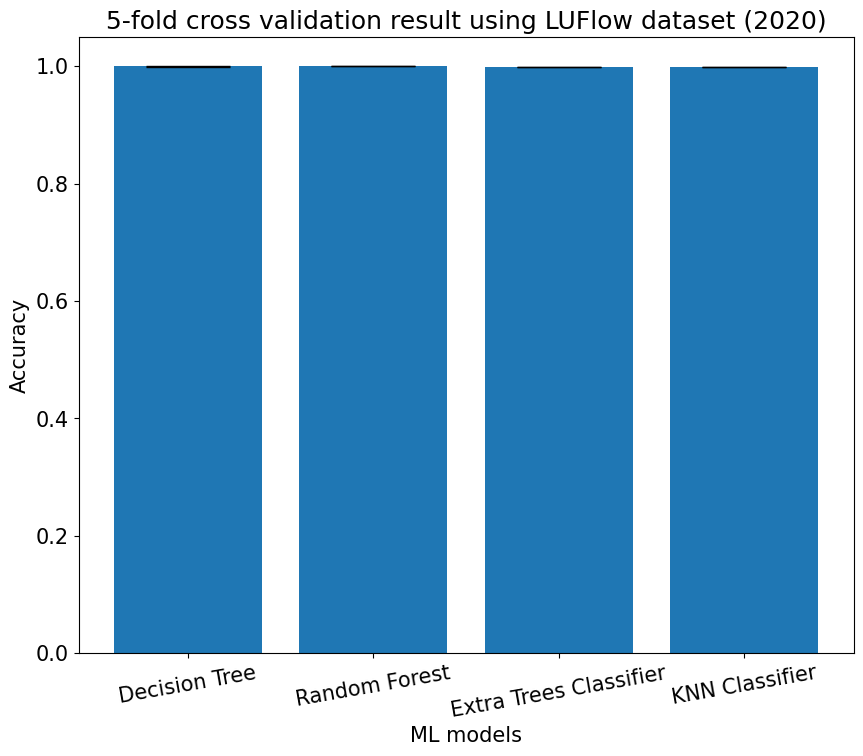

In [ ]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize= (10, 8))

# ax.boxplot(accuracy_scores.values())
ax.bar(accuracy_scores_mean.keys(),
        accuracy_scores_mean.values(),
        yerr=accuracy_scores_std.values(),
        capsize=30)
ax.set_xlabel('ML models')
ax.set_ylabel('Accuracy')
ax.set_title('5-fold cross validation result using LUFlow dataset (2020)')
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center')

plt.show()

#**6. Evaluate the performance of the models**

In [ ]:
features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/features_selected/LUFlow_RandomForestClassifier_11.csv').squeeze()
features=features.tolist() +  ['label']

In [ ]:
luflow_2020 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_cleaned/LUFlow.csv', usecols=features)
luflow_2020.shape

(1000000, 12)

In [ ]:
luflow_2021  = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dataset/LUFlow Dataset/dataset_cleaned/LUFlow2021.csv', usecols=features)
luflow_2021 .shape

(1000000, 12)

In [ ]:
luflow_2020 = luflow_2020.sample(frac=1).reset_index(drop=True)
luflow_2021 = luflow_2021.sample(frac=1).reset_index(drop=True)

In [ ]:
print(luflow_2020.shape)
print(luflow_2021.shape)

(1000000, 12)
(1000000, 12)


In [ ]:
luflow_2020_X = luflow_2020.drop('label', axis=1).copy()
luflow_2020_y = luflow_2020['label'].copy()

luflow_2020_train_X, luflow_2020_test_X, luflow_2020_train_y, luflow_2020_test_y = train_test_split(luflow_2020_X, luflow_2020_y, test_size=0.3)

In [ ]:
luflow_2021_X = luflow_2021.drop('label', axis=1).copy()
luflow_2021_y = luflow_2021['label'].copy()

In [ ]:
scalar = StandardScaler()
# only fit the training data
luflow_2020_train_X_scaled = scalar.fit(luflow_2020_train_X)

luflow_2020_train_X_scaled = scalar.transform(luflow_2020_train_X)
luflow_2020_test_X_scaled = scalar.transform(luflow_2020_test_X)
luflow_2021_X_scaled = scalar.transform(luflow_2021_X)

In [ ]:
# define the models with optimal hyperparameter retrived in Step 3


models = {
    'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_depth=11,max_features=8, splitter="best",random_state=172278),
    'Random Forest': RandomForestClassifier(bootstrap=True,n_estimators=100,max_depth=9,max_features=8, criterion="entropy",random_state=172278),
    'Extra Trees Classifier': ExtraTreesClassifier(bootstrap=False,n_estimators=100,max_depth=9,max_features=8, criterion="entropy",random_state=172278),
    'KNN Classifier': KNeighborsClassifier(n_neighbors = 3, metric="minkowski",leaf_size=30,p=2)
}

------------------------- Decision Tree -------------------------
              precision    recall  f1-score   support

      benign   0.999747  0.999520  0.999633    150074
   malicious   0.999520  0.999747  0.999633    149926

    accuracy                       0.999633    300000
   macro avg   0.999633  0.999633  0.999633    300000
weighted avg   0.999633  0.999633  0.999633    300000

------------------------- Random Forest -------------------------
              precision    recall  f1-score   support

      benign   0.999793  0.999540  0.999667    150074
   malicious   0.999540  0.999793  0.999667    149926

    accuracy                       0.999667    300000
   macro avg   0.999667  0.999667  0.999667    300000
weighted avg   0.999667  0.999667  0.999667    300000

------------------------- Extra Trees Classifier -------------------------
              precision    recall  f1-score   support

      benign   0.992599  0.974106  0.983266    150074
   malicious   0.974555  0.992

Text(0.5, 0.98, 'Figure 5: Confusion matrix of each model on LUFlow dataset (2020)')

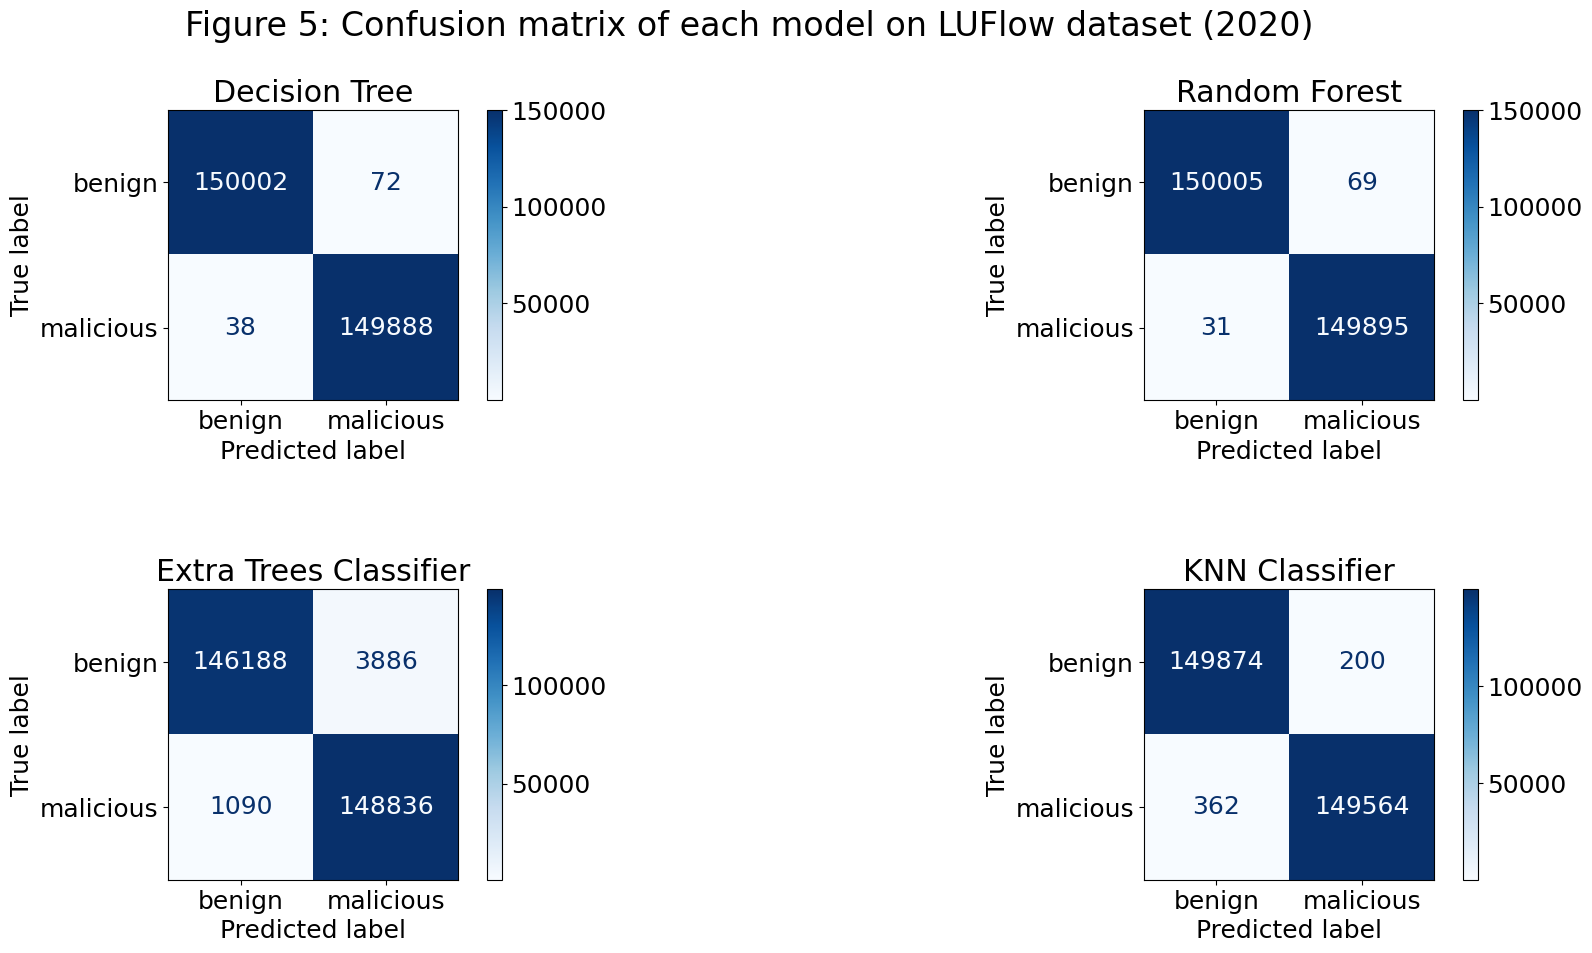

In [ ]:
trained_models = {}
training_time = {}
accuracy_train_dataset = {}
f_score_train_dataset = {}
precision_train_dataset = {}
recall_train_dataset = {}

plt.rcParams.update({'font.size': 18})
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for i, (model, clf) in enumerate(models.items()):

    training_start_time = process_time()
    clf.fit(luflow_2020_train_X_scaled, luflow_2020_train_y)

    # save the training time
    training_time[model] = process_time() - training_start_time

    # save the trained model
    trained_models[model] = clf

    prediction = clf.predict(luflow_2020_test_X_scaled)
    model_report = metrics.classification_report(luflow_2020_test_y, prediction, digits=6, output_dict=True)

    # save the accuracy and the f1-score of each model
    accuracy_train_dataset[model] = model_report['accuracy']
    f_score_train_dataset[model] = model_report['weighted avg']['f1-score']
    precision_train_dataset[model] = model_report['weighted avg']['precision']
    recall_train_dataset[model] = model_report['weighted avg']['recall']

    print(f"{'-'*25} {model} {'-'*25}")
    print(metrics.classification_report(luflow_2020_test_y, prediction, digits=6))

    ConfusionMatrixDisplay.from_estimator(clf,
                            luflow_2020_test_X_scaled,
                            luflow_2020_test_y,
                            cmap=plt.cm.Blues,
                            ax=axes[math.floor(i/2)][i%2])

    axes[math.floor(i/2)][i%2].set_title(model)




fig.subplots_adjust(hspace=0.65, wspace=0.7)
fig.suptitle('Figure 5: Confusion matrix of each model on LUFlow dataset (2020)', fontsize=24)

###Evaluate the model using LUFlow2021 dataset

------------------------- Decision Tree -------------------------
              precision    recall  f1-score   support

      benign   0.999444  0.999634  0.999539    500000
   malicious   0.999634  0.999444  0.999539    500000

    accuracy                       0.999539   1000000
   macro avg   0.999539  0.999539  0.999539   1000000
weighted avg   0.999539  0.999539  0.999539   1000000

------------------------- Random Forest -------------------------
              precision    recall  f1-score   support

      benign   0.999732  0.999592  0.999662    500000
   malicious   0.999592  0.999732  0.999662    500000

    accuracy                       0.999662   1000000
   macro avg   0.999662  0.999662  0.999662   1000000
weighted avg   0.999662  0.999662  0.999662   1000000

------------------------- Extra Trees Classifier -------------------------
              precision    recall  f1-score   support

      benign   0.986096  0.973914  0.979967    500000
   malicious   0.974232  0.986

Text(0.5, 0.98, 'Figure 6: Confusion matrix of each model on LUFlow dataset (2021)')

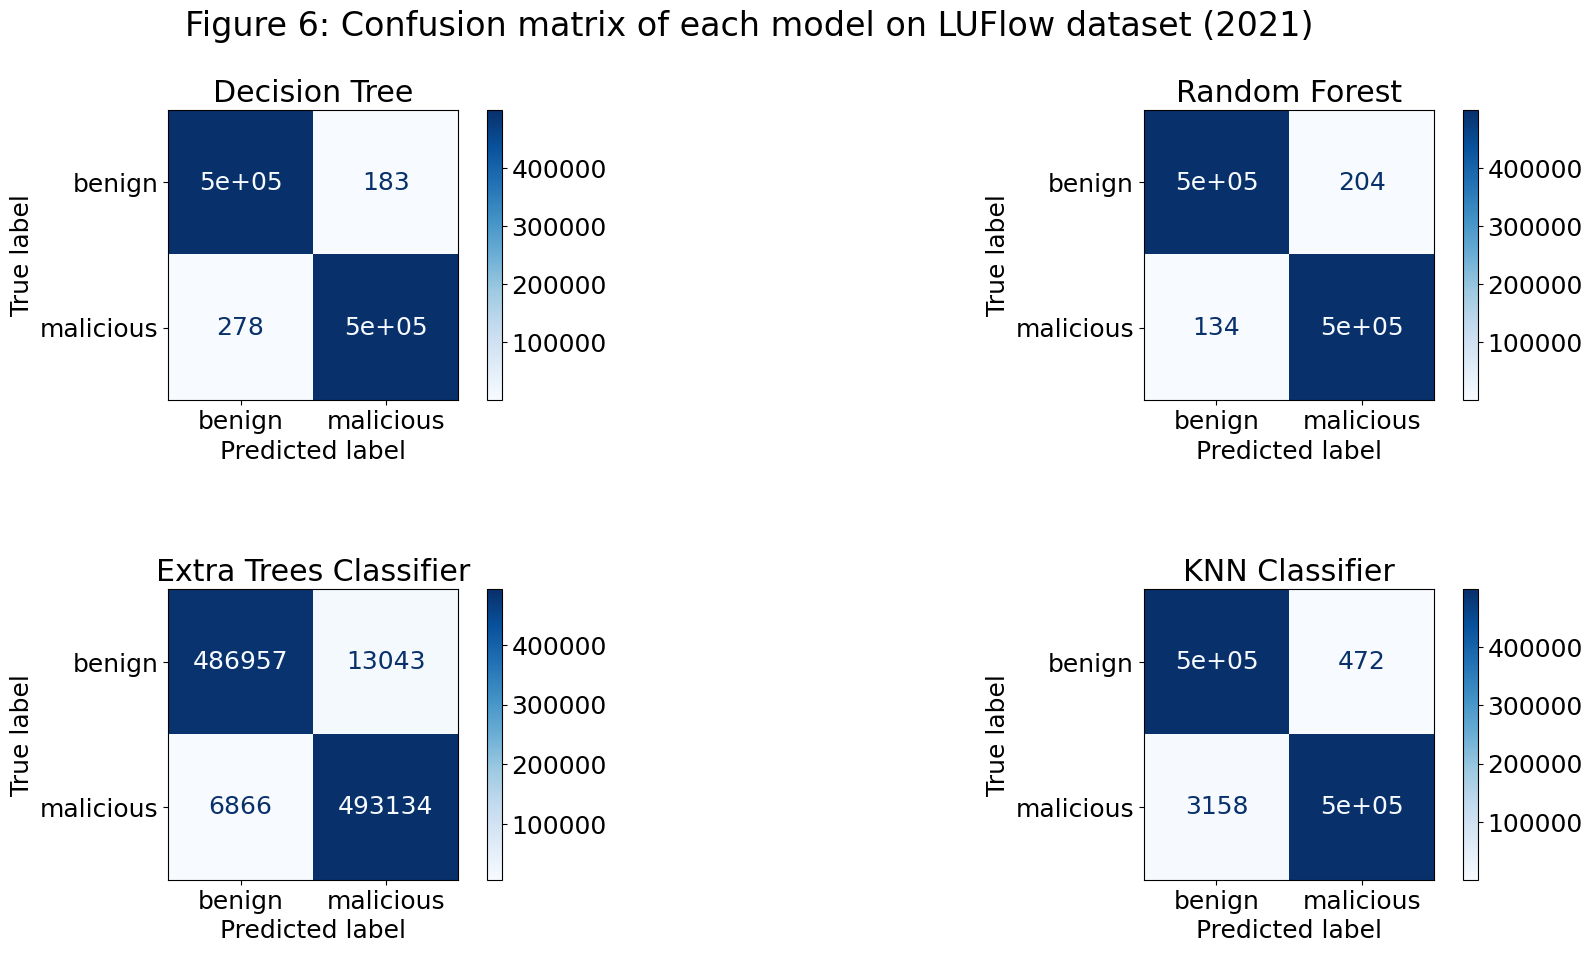

In [ ]:
prediction_time = {}
accuracy_testing_dataset = {}
f_score_testing_dataset = {}
precision_testing_dataset = {}
recall_testing_dataset = {}

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for i, (model, clf) in enumerate(trained_models.items()):
    clf = trained_models[model]

    prediction_start_time = process_time()
    prediction = clf.predict(luflow_2021_X_scaled)

    # save the time consumption for prediction
    prediction_time[model] = process_time() - prediction_start_time

    model_report = metrics.classification_report(luflow_2021_y, prediction, digits=6, output_dict=True)

    # save the accuracy and the f1-score of each model
    accuracy_testing_dataset[model] = model_report['accuracy']
    f_score_testing_dataset[model] = model_report['weighted avg']['f1-score']
    precision_testing_dataset[model] = model_report['weighted avg']['precision']
    recall_testing_dataset[model] = model_report['weighted avg']['recall']

    print(f"{'-'*25} {model} {'-'*25}")
    print(metrics.classification_report(luflow_2021_y, prediction, digits=6))

    ConfusionMatrixDisplay.from_estimator(clf,
                            luflow_2021_X_scaled,
                            luflow_2021_y,
                            cmap=plt.cm.Blues,
                            ax=axes[math.floor(i/2)][i%2])

    axes[math.floor(i/2)][i%2].set_title(model)


fig.subplots_adjust(hspace=0.65, wspace=0.7)
fig.suptitle('Figure 6: Confusion matrix of each model on LUFlow dataset (2021)', fontsize=24)

##Comparison

In [ ]:
# define function to create label on top of the bars
def label_top(rects):
    for rect in rects:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2, height, f"{height:.6f}", ha='center', va='bottom')

###Accuracy

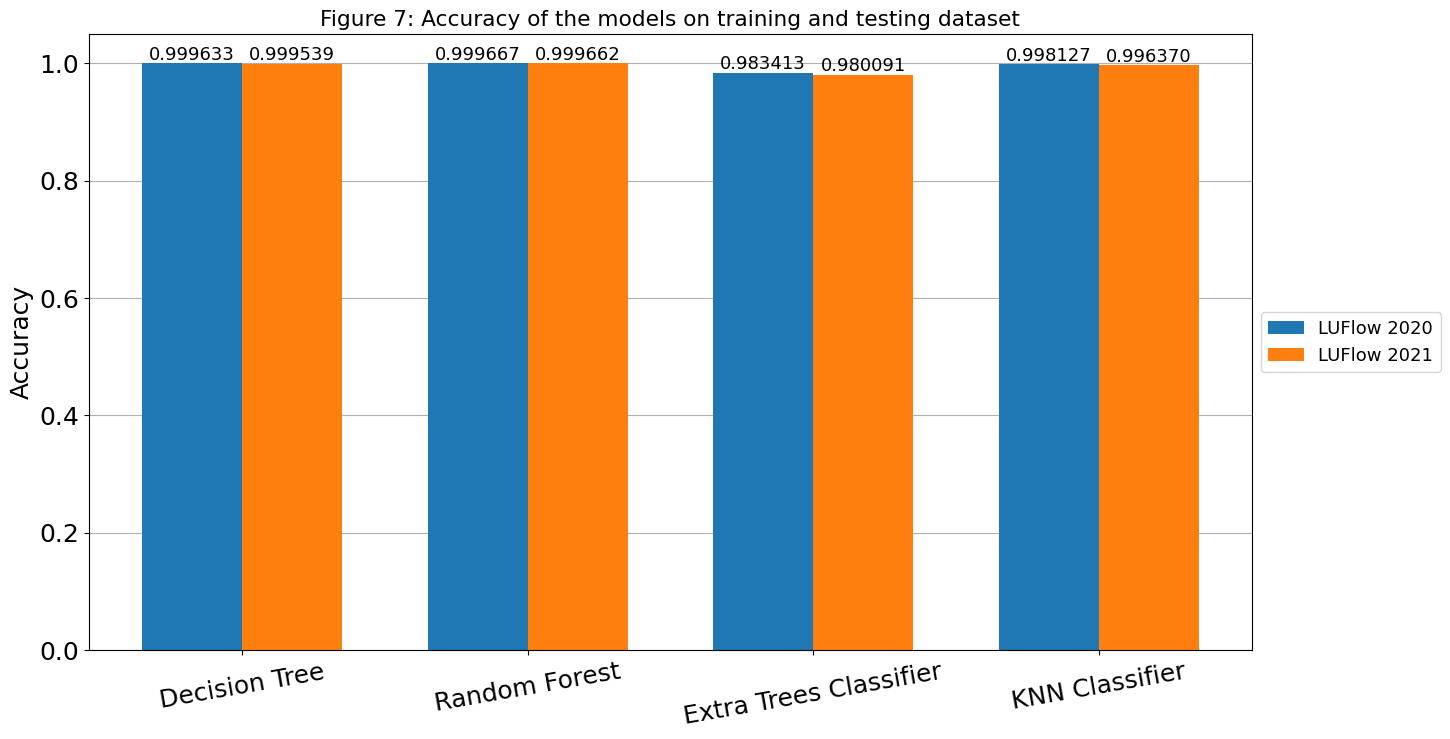

In [ ]:
fig, ax = plt.subplots(figsize= (15, 8))
plt.rcParams.update({'font.size': 13})

x = np.arange(len(accuracy_train_dataset.keys())) # label location
width = 0.35 # width of the bar

bar1 = ax.bar(x - width/2, accuracy_train_dataset.values(), width, label='LUFlow 2020')
bar2 = ax.bar(x + width/2, accuracy_testing_dataset.values(), width, label='LUFlow 2021')

ax.set_ylabel('Accuracy')
ax.set_title('Figure 7: Accuracy of the models on training and testing dataset')
ax.set_xticks(x)
ax.set_xticklabels(accuracy_train_dataset.keys())
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center') # rotate the label
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

# put a legend to the right of the axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

label_top(bar1)
label_top(bar2)

plt.show()

###F1-score

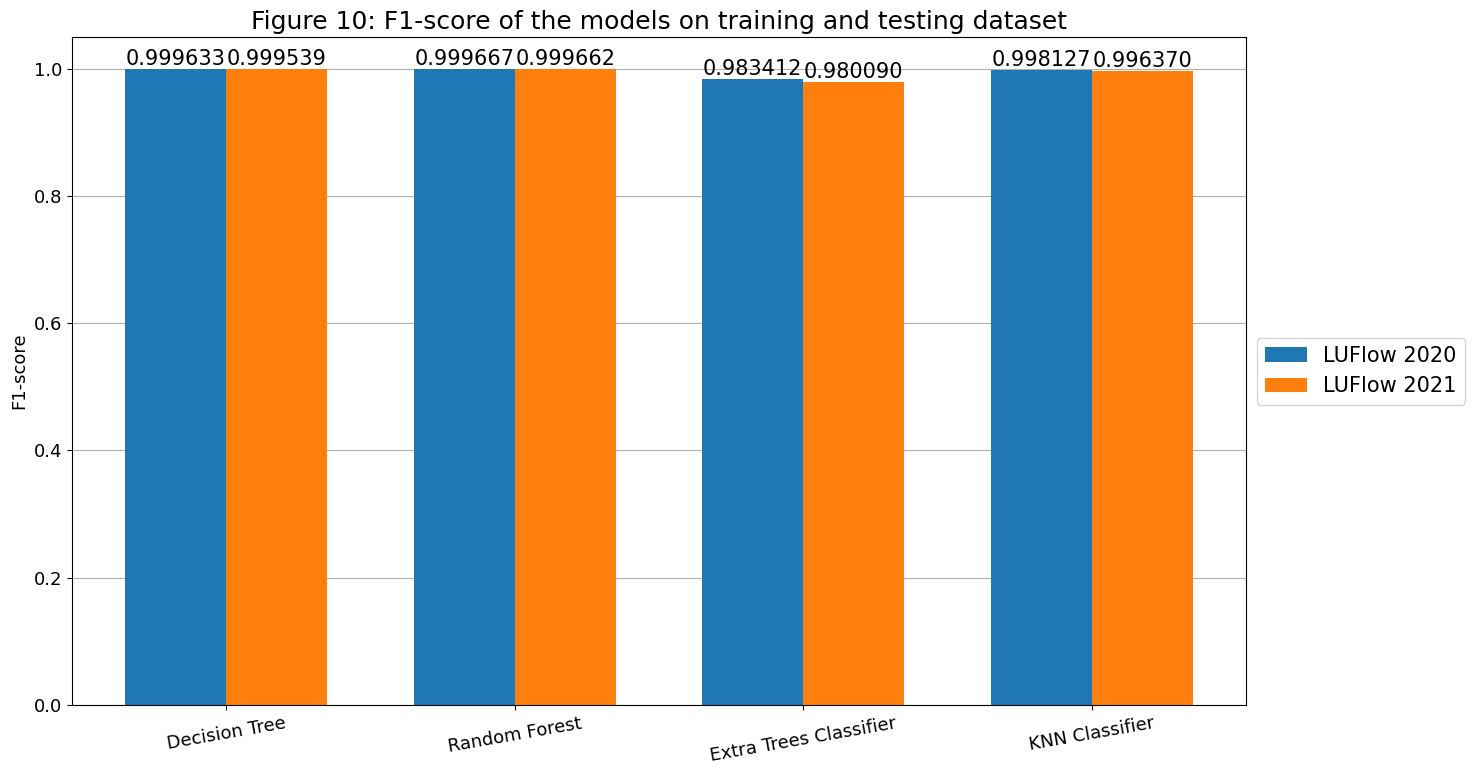

In [ ]:
fig, ax = plt.subplots(figsize= (15, 8))
plt.rcParams.update({'font.size': 15})

x = np.arange(len(f_score_train_dataset.keys())) # label location
width = 0.35 # width of the bar

bar1 = ax.bar(x - width/2, f_score_train_dataset.values(), width, label='LUFlow 2020')
bar2 = ax.bar(x + width/2, f_score_testing_dataset.values(), width, label='LUFlow 2021')

ax.set_ylabel('F1-score')
ax.set_title('Figure 10: F1-score of the models on training and testing dataset')
ax.set_xticks(x)
ax.set_xticklabels(f_score_train_dataset.keys())
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center') # rotate the label
ax.legend()
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

# put a legend to the right of the axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

label_top(bar1)
label_top(bar2)

fig.tight_layout()

plt.show()

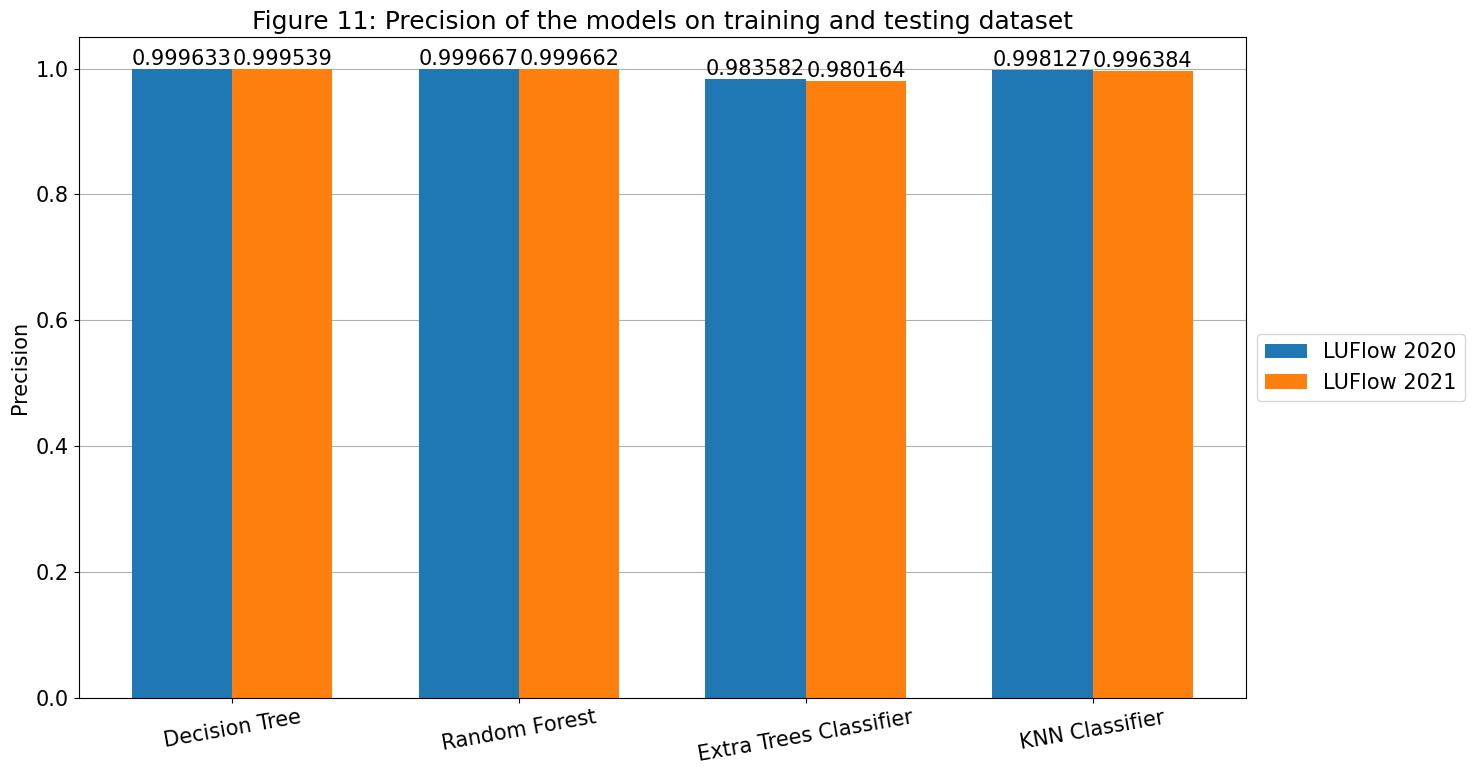

In [ ]:
fig, ax = plt.subplots(figsize= (15, 8))
plt.rcParams.update({'font.size': 15})
# precision_train_dataset = {}
# recall_train_dataset = {}
x = np.arange(len(precision_train_dataset.keys())) # label location
width = 0.35 # width of the bar

bar1 = ax.bar(x - width/2, precision_train_dataset.values(), width, label='LUFlow 2020')
bar2 = ax.bar(x + width/2, precision_testing_dataset.values(), width, label='LUFlow 2021')

ax.set_ylabel('Precision')
ax.set_title('Figure 11: Precision of the models on training and testing dataset')
ax.set_xticks(x)
ax.set_xticklabels(precision_train_dataset.keys())
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center') # rotate the label
ax.legend()
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

# put a legend to the right of the axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

label_top(bar1)
label_top(bar2)

fig.tight_layout()

plt.show()

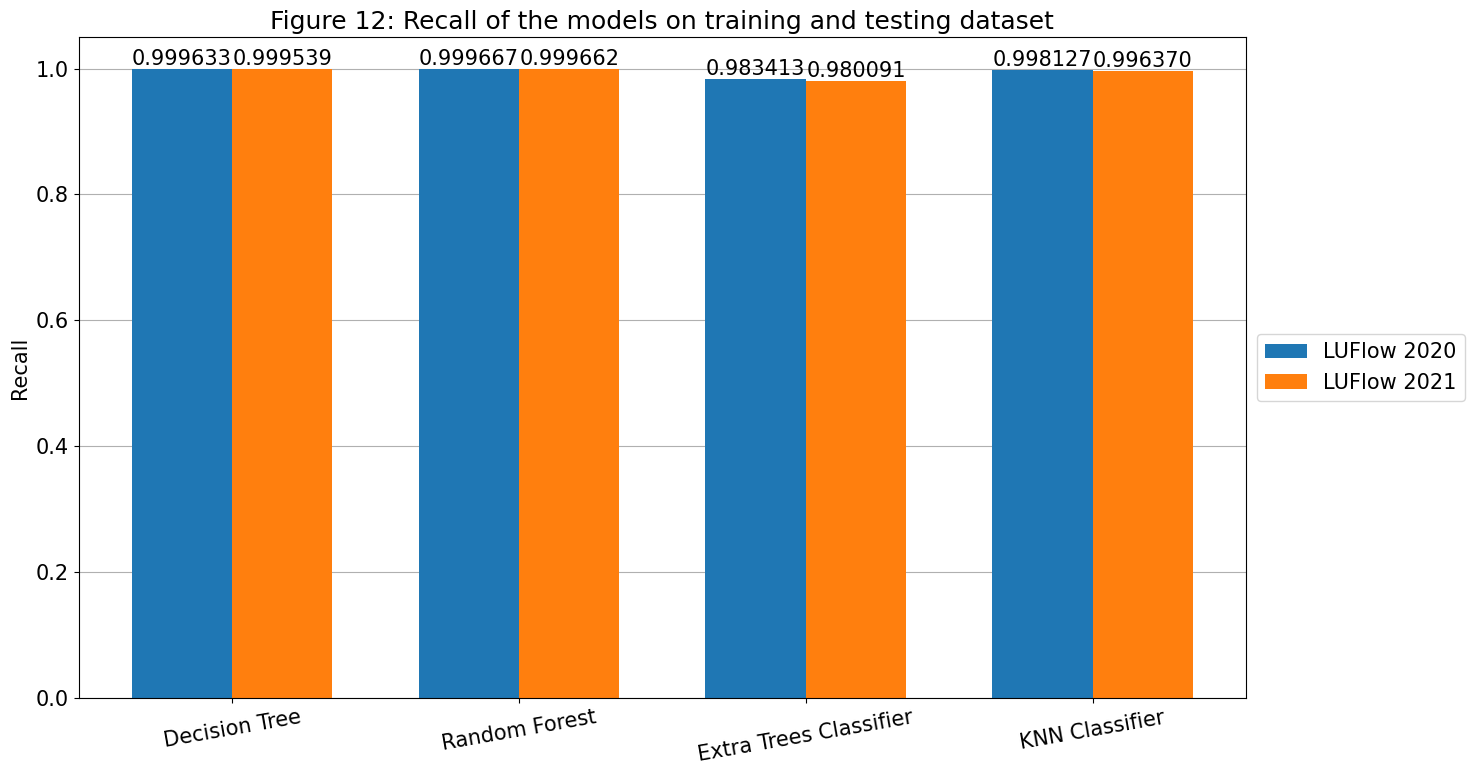

In [ ]:
fig, ax = plt.subplots(figsize= (15, 8))
plt.rcParams.update({'font.size': 15})

x = np.arange(len(recall_train_dataset.keys())) # label location
width = 0.35 # width of the bar

bar1 = ax.bar(x - width/2, recall_train_dataset.values(), width, label='LUFlow 2020')
bar2 = ax.bar(x + width/2, recall_testing_dataset.values(), width, label='LUFlow 2021')

ax.set_ylabel('Recall')
ax.set_title('Figure 12: Recall of the models on training and testing dataset')
ax.set_xticks(x)
ax.set_xticklabels(recall_train_dataset.keys())
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center') # rotate the label
ax.legend()
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

# put a legend to the right of the axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

label_top(bar1)
label_top(bar2)

fig.tight_layout()

plt.show()

###Time consumption for training

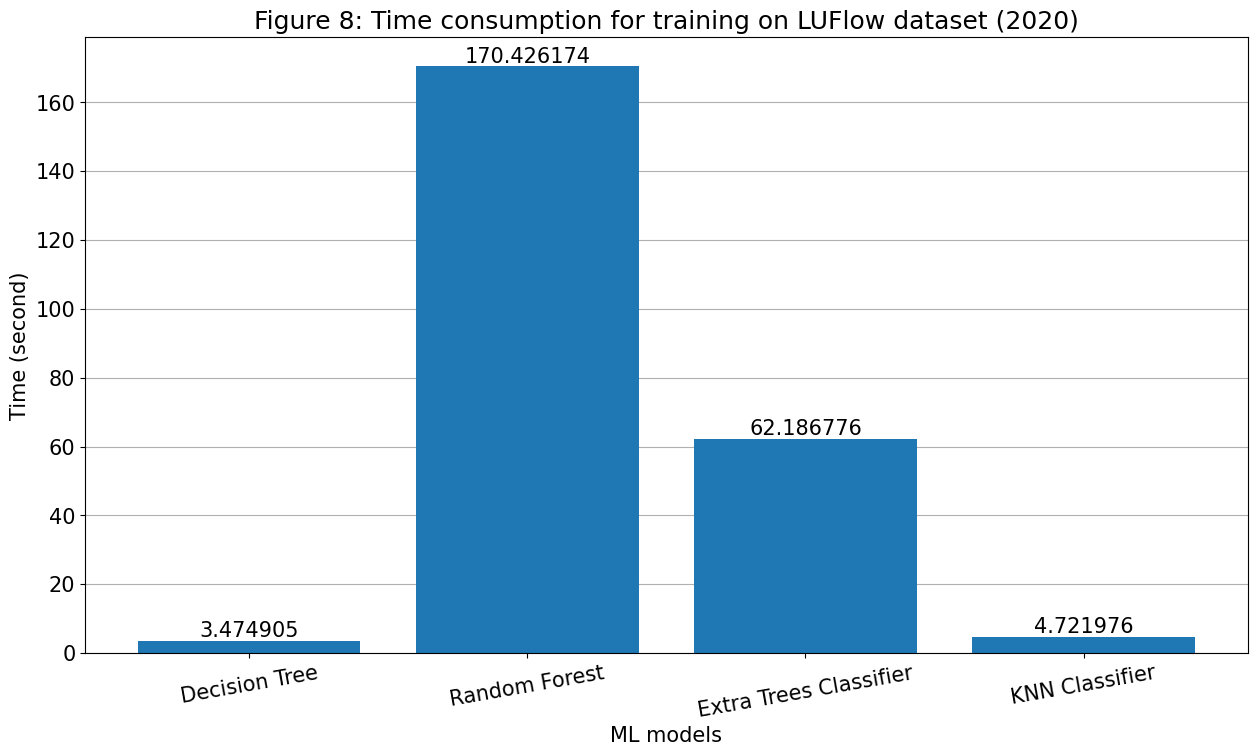

In [ ]:
fig, ax = plt.subplots(figsize= (15, 8))

bar = ax.bar(training_time.keys(), training_time.values())
ax.set_xlabel("ML models")
ax.set_ylabel("Time (second)")
ax.set_title("Figure 8: Time consumption for training on LUFlow dataset (2020)")
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center') # rotate the label
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

label_top(bar)

plt.show()

###Time consumption for prediction

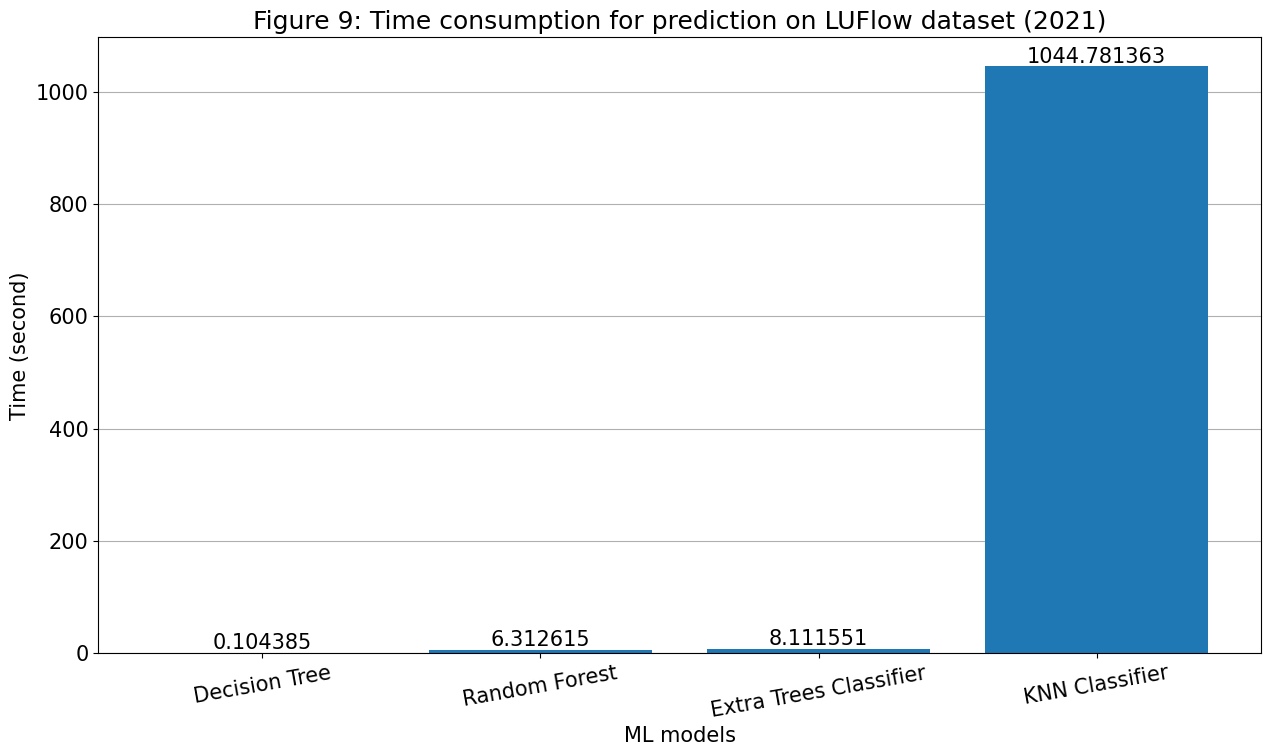

In [ ]:
fig, ax = plt.subplots(figsize= (15, 8))

bar = ax.bar(prediction_time.keys(), prediction_time.values())
ax.set_xlabel("ML models")
ax.set_ylabel("Time (second)")
ax.set_title("Figure 9: Time consumption for prediction on LUFlow dataset (2021)")
plt.setp(ax.get_xticklabels(), rotation=10, horizontalalignment='center')
ax.grid(axis='y')
ax.set_axisbelow(True) # set the grid behind the bars

label_top(bar)

plt.show()